<a href="https://colab.research.google.com/github/Iana9/DS/blob/main/Dating_model_with_flask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-surprise
from surprise import Dataset, Reader, SVD
from surprise.accuracy import rmse
from hyperopt import hp, fmin, Trials, tpe
from surprise.model_selection import train_test_split
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
import os
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
class model_surp():
    """
    Описание
    --------
    Класс для создания объектра рекомендательной системы

    Атрибуты
    --------
    pkl_filename : str
        путь/файл для сохранения модели

    Методы
    -------
    load_data(path="/content/rec-libimseti-dir.edges"):
        метод для загрузки данных из указанного пути
    show_set():
        метод для создания дестрибуции на датасете
    create_model(cut_users = 150, cut_items = 20)
        метод для обучения модели
    recommened(rec=)
        метод для рекомендации для user_id
    """
    def __init__(self, file_name : str = "pickle_model.pkl"):
        self.pkl_filename = file_name
        self.reader = Reader(rating_scale=(1, 10)) # Зададим разброс оценок
        self.rate = None
        self.model = self.find_model()

    def find_model(self):
        """
        Описание
        --------
        Метод для использования уже обученной модели, если она находится по атрибуту pkl_filename
        """
        if os.path.exists(self.pkl_filename):
            while True:
                answer = input(f"Model was found in {self.pkl_filename}. Do you want to use it?[y/n]")
                if answer.isalpha() and answer.lower().replace(" ", "") in ['y', 'yes']:
                    return self.__open_model()
                elif answer.isalpha() and answer.lower().replace(" ", "") in ['n', 'no']:
                    return None
                else:
                    print(f"Don't get your answer {answer}. Please try again.")
                    continue
        else:
            return None

    def __open_model(self):
        with open(self.pkl_filename, 'rb') as file:
            return pickle.load(file)

    def load_data(self, path: str = "/content/rec-libimseti-dir.edges"):
        """
        Описание
        ---------
        Метод для считывания данных и приводения их в формат для использования модулем surprise

        Атрибуты
        ---------
        path : str
          путь к файлу с данными для обучения
        """

        self.rate = pd.read_csv(path,
                                delim_whitespace=True,
                                skiprows=1,
                                names=["id_from", "id_to", "rating"])
        self.rate.columns = ['userID', 'itemID', 'rating']
        self.rate.dropna(inplace=True)

    def show_set(self):
        """
        Описание
        --------
        Метод для создания 3 субплотов распределения по данным: по оценкам, по лайкнувшим пользователям
        и по лайкнутым пользователям
        """

        fig, axs = plt.subplots(nrows=3, figsize=(8, 8))
        for num, func in enumerate([self.__rating_destribution, self.__user_destribution, self.__item_destribution]):
            func(axs[num])
        fig.tight_layout()

    def __rating_destribution(self, ax: plt.Axes):
        ax = sns.histplot(self.rate['rating'], bins=10, stat="percent", ax=ax)
        ax.set(xticks=self.rate.rating.unique())
        ax.set_xlabel("Рейтинг")
        ax.set_ylabel("Количество оценок, %");

    def __user_destribution(self, ax: plt.Axes):
        data = self.rate.groupby('userID')['rating'].count().sort_values().clip(upper=1000).reset_index()
        ax = sns.histplot(data, x=data.rating, log_scale=True, ax=ax)
        ax.set_xlabel("Количество оценок от пользователя")
        ax.set_ylabel("Количество пользователей");

    def __item_destribution(self, ax: plt.Axes):
        data = self.rate.groupby('itemID')['rating'].count().sort_values().clip(upper=200).reset_index()
        ax = sns.histplot(data, x=data.rating, log_scale=True, ax=ax)
        ax.set_xlabel("Количество оценок у пользователя")
        ax.set_ylabel("Количество пользователей");

    def create_model(self, cut_users: int = 400, cut_items: int = 60):
        """
        Описание
        ---------
        Метод для обучения модели на обработанных данных

        Параметры
        ----------
        cut_users : int
            убрать пользователей, который поставил оценок меньше указанного параметра
        cut_items : int
            убрать пользователей, который получил оценок меньше указанного параметра
        """

        self.model = None
        print("User description:", end='\n')
        print(tabulate(self.rate['userID'].value_counts().describe().reset_index(), headers='keys', tablefmt='psql', showindex=False, numalign="right"))
        print("Item description:\n", end='\n')
        print(tabulate(self.rate['itemID'].value_counts().describe().reset_index(), headers='keys', tablefmt='psql', showindex=False, numalign="right"))
        cut_users = int(input("Cut users by rating count:") or cut_users)
        cut_items = int(input("Cut item by rating count:") or cut_items)
        df = self.rate
        filter_items = df['itemID'].value_counts() > cut_items
        filter_items = filter_items[filter_items].index.tolist()

        filter_users = df['userID'].value_counts() > cut_users
        filter_users = filter_users[filter_users].index.tolist()
        df = df[(df['itemID'].isin(filter_items)) & (df['userID'].isin(filter_users))]
        print(f"Remaining rows in set: {df.shape[0]}")
        self.trainset, self.testset = train_test_split(
                                                      Dataset.load_from_df(df[['userID', 'itemID', 'rating']], self.reader),
                                                      test_size=0.25)
        max_evals = 30
        space = {
            "n_factors" : hp.randint('k', 1, 50),
            "n_epochs" : hp.randint('n_epochs', 1, 20),
            "reg_pu" : hp.uniform('reg_u', 0.001, 1),
            "reg_qi" : hp.uniform('reg_i',  0.001, 1)
        }
        trials = Trials()
        best=fmin(fn=self.__train_rmse, # оптимизируемая функция
                  space=space, 
                  algo=tpe.suggest, # алгоритм оптимизации, hyperotp выберет свои параметры автоматически
                  max_evals=max_evals, # максимальное количество итераций
                  trials=trials)
        self.__train_fulland_save(best)
        del self.trainset, self.testset

    def __train_rmse(self, params: dict):
        params = {
            "n_factors" : int(params["n_factors"]),
            "n_epochs" : int(params["n_epochs"]),
            "reg_pu" : params["reg_pu"],
            'reg_qi' : params['reg_qi']
        }

        model = SVD(**params)
        model = model.fit(self.trainset)
        predictions = model.test(self.testset)
        return rmse(predictions)

    def __train_fulland_save(self, params: dict):
        data = Dataset.load_from_df(self.rate[['userID', 'itemID', 'rating']], self.reader) #создадим объект, с которым умеет работать библиотека
        params = {
            "n_factors" : int(params["k"]),
            "n_epochs" : int(params["n_epochs"]),
            "reg_pu" : params["reg_u"],
            'reg_qi' : params['reg_i']
        }
        model = SVD(**params)
        model.fit(data.build_full_trainset())
        with open(self.pkl_filename, 'wb') as file:
            pickle.dump(model, file)

    def recommened(self, rec: int):
        """
        Описание
        --------
        1. Рекомендация 10 пользователей, которого указанный пользователь лайкнет
        2. Пользователи, которые лайкнут указанного пользователя в ответ

        Параметры
        ---------
        rec : int
            id пользователя для рекомендации
        """

        if not self.model:
            self.model = self.__open_model()

        iid = self.rate["itemID"].unique()
        recom = self.rate.loc[self.rate.userID == rec, 'itemID']
        iids_to_pred = np.setdiff1d(iid, recom)

        testset = [[rec, iid, 5.] for iid in iids_to_pred]
        predictions1 = self.model.test(testset)
        pred_ratings1 = np.array([pred.est for pred in predictions1])             

        testset = [[iid, rec, 5.] for iid in iids_to_pred]
        predictions2 = self.model.test(testset)
        pred_ratings2 = np.array([pred.est for pred in predictions2]) 
        mutual_likes = np.logical_and(np.array(pred_ratings1) >= 6, np.array(pred_ratings2) >= 6)
        cut_mutual = 10 if mutual_likes.sum() > 10 else mutual_likes.sum()
        return f"Recommendation for user {rec}: {', '.join(map(str, np.array(iids_to_pred)[np.argpartition(np.array(pred_ratings1), -10)[-10:]]))}",\
               f"""Mutual likes of user {rec}: {', '.join(map(str, np.array(iids_to_pred)[np.argpartition(np.where(mutual_likes == False, 
                                                                                               0, 
                                                                                               np.array(pred_ratings2)), -cut_mutual)[-cut_mutual:]]))}"""

In [7]:
print(model_surp.__doc__)
m = model_surp()


    Описание
    --------
    Класс для создания объектра рекомендательной системы

    Атрибуты
    --------
    pkl_filename : str
        путь/файл для сохранения модели

    Методы
    -------
    load_data(path="/content/rec-libimseti-dir.edges"):
        метод для загрузки данных из указанного пути
    show_set():
        метод для создания дестрибуции на датасете
    create_model(cut_users = 150, cut_items = 20)
        метод для обучения модели
    recommened(rec=)
        метод для рекомендации для user_id
    
Model was found in pickle_model.pkl. Do you want to use it?[y/n]y


In [9]:
print(m.load_data.__doc__)
m.load_data()


        Описание
        ---------
        Метод для считывания данных и приводения их в формат для использования модулем surprise

        Атрибуты
        ---------
        path : str
          путь к файлу с данными для обучения
        



        Описание
        --------
        Метод для создания 3 субплотов распределения по данным: по оценкам, по лайкнувшим пользователям
        и по лайкнутым пользователям
        


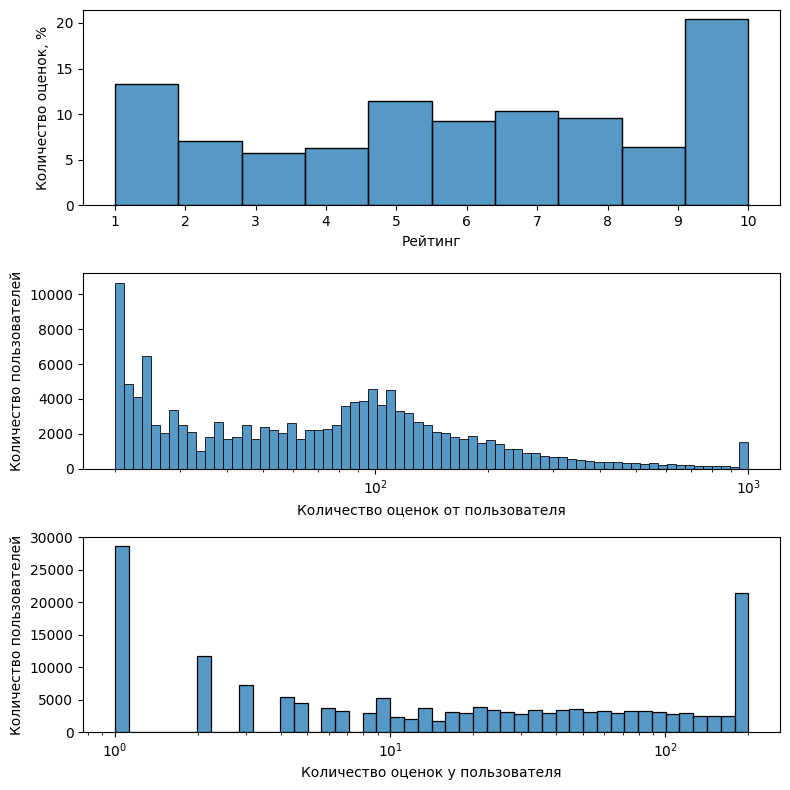

In [ ]:
print(m.show_set.__doc__)
m.show_set()

In [5]:
print(m.create_model.__doc__)
m.create_model()


        Описание
        ---------
        Метод для обучения модели на обработанных данных

        Параметры
        ----------
        cut_users : int
            убрать пользователей, который поставил оценок меньше указанного параметра
        cut_items : int
            убрать пользователей, который получил оценок меньше указанного параметра
        
User description:
+---------+----------+
| index   |   userID |
|---------+----------|
| count   |   135359 |
| mean    |  128.247 |
| std     |  378.413 |
| min     |       20 |
| 25%     |       29 |
| 50%     |       73 |
| 75%     |      124 |
| max     |    25042 |
+---------+----------+
Item description:

+---------+----------+
| index   |   itemID |
|---------+----------|
| count   |   168791 |
| mean    |  102.845 |
| std     |  413.712 |
| min     |        1 |
| 25%     |        3 |
| 50%     |       17 |
| 75%     |       76 |
| max     |    33389 |
+---------+----------+
Cut users by rating count:
Cut item by rating count:

In [10]:
print(m.recommened.__doc__)
for i in [98447, 111944, 111930, 82091, 125299, 125298, 17335, 60356]:
    print("\n".join(m.recommened(i)), end="\n"+"-"*175+"\n")


        Описание
        --------
        1. Рекомендация 10 пользователей, которого указанный пользователь лайкнет
        2. Пользователи, которые лайкнут указанного пользователя в ответ

        Параметры
        ---------
        rec : int
            id пользователя для рекомендации
        
Recommendation for user 98447: 75391, 188337, 151000, 61968, 201540, 22319, 165800, 124953, 159740, 44232
Mutual likes of user 98447: 9276, 65602, 75169, 60973, 95059, 78136, 23912, 105176, 36408, 73705
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Recommendation for user 111944: 75815, 47802, 53134, 135081, 148812, 206737, 122775, 173752, 179800, 167929
Mutual likes of user 111944: 153682, 153680, 45984, 45981, 45986, 153681, 153685, 153683, 153684, 136584
-------------------------------------------------------------------------------------------------------------

In [ ]:
!pip install flask-ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from flask_ngrok import run_with_ngrok
from flask import Flask, request, render_template
!ngrok authtoken #authtoken

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
app = Flask(__name__)
run_with_ngrok(app)

@app.route('/')
def home():
    return render_template('index.html')

@app.route('/recommend', methods=['POST'])
def recommend():
    input = [int(x) for x in request.form.values()]
    prediction = m.recommened(*input)

    return render_template('index.html', output1=f"{prediction[0]}", output2=f"{prediction[1]}")

app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://5e7f-35-230-171-177.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [27/Apr/2023 16:41:31] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Apr/2023 16:41:31] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [27/Apr/2023 16:41:42] "POST /recommend HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Apr/2023 16:41:54] "POST /recommend HTTP/1.1" 200 -
